In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim

print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

2023-07-20 14:35:26.323895: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1.23.5
1.5.3
2.12.0
3.7
3.8.3


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from konlpy.tag import Mecab,Okt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

## Step 1. 데이터 다운로드

In [3]:
import zipfile

# specify the zip file name
zip_file_name = './data/ko.zip'

# open the zip file in read mode
with zipfile.ZipFile(zip_file_name, 'r') as zip:
    # extract all files
    zip.extractall()
    print(f'Extracted all files from {zip_file_name}')

Extracted all files from ./data/ko.zip


### Data 불러오기

In [4]:
# 데이터 불러오기
data = pd.read_csv('./data/ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
question = data['Q']
answer = data['A']

## Step 2. 데이터 정제

In [6]:
import re
def preprocess_sentence_kor(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^가-힣0-9a-zA-Z?.!,]+", " ", sentence)
    return sentence

In [7]:
import builtins

def duplication_check(corpus1, corpus2):
    #zipped = zip(corpus1, corpus2)
    zipped = builtins.zip(corpus1, corpus2)
    #unique_pairs = set(zipped)
    unique_pairs = set(map(lambda x: (tuple(x[0]), tuple(x[1])), zipped))
    
    unique_pairs = list(unique_pairs)
    corpus1, corpus2 = builtins.zip(*unique_pairs)
    #corpus1, corpus2 = unique_pairs

    return corpus1,corpus2

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sentence_lengths(series):
    # Calculate the length of each sentence in the Series
    lengths = series.str.len()

    # Plot a histogram of sentence lengths
    lengths.plot.hist()
    plt.show()


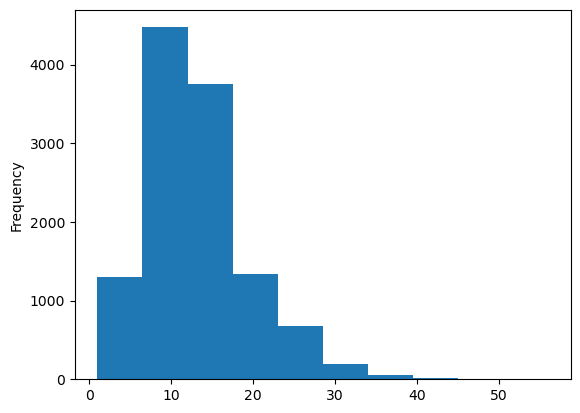

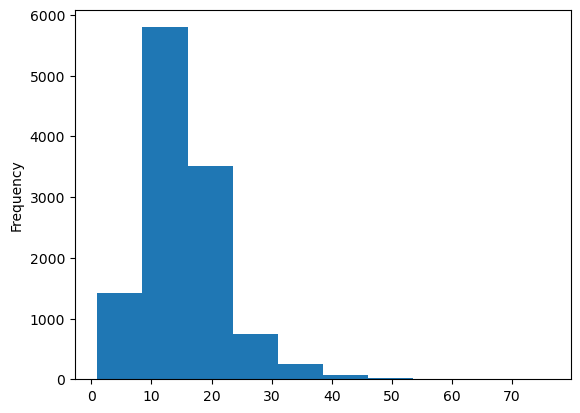

In [9]:
plot_sentence_lengths(question)
plot_sentence_lengths(answer)

In [10]:
MAX_LENGTH = 40

## Step 3. 데이터 토큰화

In [11]:
def sentence_tokenizer(corpus1, corpus2):
    mecab_corpus_q = []
    mecab_corpus_a = []
    m = Mecab()
    
    for sentence in corpus1:
        mecab_corpus_q.append(m.morphs(sentence))
    
    for sentence in corpus2:
        mecab_corpus_a.append(m.morphs(sentence))
    
    #print(mecab_corpus_q,mecab_corpus_a )
    #zipped = zip(mecab_corpus_q, mecab_corpus_a)
    zipped = builtins.zip(mecab_corpus_q, mecab_corpus_a)
    zipped_pd = pd.DataFrame(zipped, columns=['Q', 'A'])
    #tokens_zipped_pd.head()
    
    mask = (zipped_pd['Q'].str.len() <= MAX_LENGTH) & (zipped_pd['A'].str.len() <= MAX_LENGTH)
    result = zipped_pd[mask]
    #print(result)
    
    corpus1 = result['Q']
    corpus2 = result['A']
    
    return corpus1, corpus2

In [12]:
from konlpy.tag import Mecab

def build_corpus(corpus1, corpus2):
    corpus1 = list(map(preprocess_sentence_kor,corpus1))  # 영문 대문자 소문자로 바꾸고 한글 정규 표현 적용
    corpus2 = list(map(preprocess_sentence_kor, corpus2))
    corpus1, corpus2 = sentence_tokenizer(corpus1,corpus2) # mecab.morph|s 형태소 분석기 사용, 문장길이 40으로 제한
    que_corpus, ans_corpus =  duplication_check(corpus1, corpus2)  # 중복 체크
    
    return que_corpus, ans_corpus

In [13]:
que_corpus, ans_corpus =  build_corpus(question, answer)
len(que_corpus), len(ans_corpus)

(11746, 11746)

## Step 4. Augmentation

In [14]:
from gensim.models import Word2Vec

# Load the pre-trained Korean(w) Word2Vec model
model = Word2Vec.load('./data/ko.bin')

In [15]:
def lexical_sub_augmentation(tokenized_sentence, model):
    n=3
    similar_words=[]
    
    for r in range(3):
        for word in tokenized_sentence:
            similar_words.append(word)
            if word in model.wv:
                for i in range(n):
                    similar_words.append(model.wv.most_similar(word, topn=n)[i][0])
        break
    return  similar_words

In [16]:
que_corpus_aumented = []

for tokenized_sentence in que_corpus:
    augmented_sentence = lexical_sub_augmentation(tokenized_sentence, model)
    if augmented_sentence is not None: 
        que_corpus_aumented.append(augmented_sentence)

In [17]:
len(que_corpus), len(que_corpus_aumented),len(que_corpus[0]), len(que_corpus_aumented[0])

(11746, 11746, 4, 16)

## Step 5. 데이터 벡터화

### 타겟 데이터 전체에 <start> 토큰과 <end> 토큰을 추가

In [18]:
def adding_special_tokens(corpus):
    print(len(corpus))
    temp = []
    for sentence in corpus:
        temp.append( ["<start>"] + list(sentence) + ["<end>"])
    
    return temp

In [19]:
ans_corpus_special_token = adding_special_tokens(ans_corpus)

11746


In [20]:
len(que_corpus_aumented), len(ans_corpus_special_token)

(11746, 11746)

### Vectorizing

In [21]:
from gensim.models import KeyedVectors
from typing import List

def vectorize_corpus(corpus, model):
    vectorized_corpus = []
    for sentence in corpus:
        vectorized_sentence = []
        for word in sentence:
            if word in model.wv:
                vector = model.wv[word]
                vectorized_sentence.append(vector)
        vectorized_corpus.append(vectorized_sentence)
    return vectorized_corpus


In [23]:
enc_train = vectorize_corpus(que_corpus_aumented, model)
dec_train = vectorize_corpus(ans_corpus_special_token, model)

max_input_length_enc = max(len(sublist) for sublist in enc_train)
max_input_length_dec = max(len(sublist) for sublist in dec_train)
max_input_length = max(max_input_length_enc, max_input_length_dec)

enc_train_padding = pad_sequences(enc_train, maxlen=max_input_length, dtype='float32')
dec_train_padding = pad_sequences(dec_train, maxlen=max_input_length, dtype='float32')


BATCH_SIZE = 64
#train_dataset = tf.data.Dataset.from_tensor_slices((enc_train_padding, dec_train_padding))
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train_padding, dec_train_padding)).batch(batch_size=BATCH_SIZE)

2023-07-20 14:39:57.674805: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
enc_train_padding[0], dec_train_padding[0]

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.43459892,  0.5294219 , -1.3228387 , ..., -0.5086767 ,
         -0.7872419 , -0.44559422],
        [ 0.7317492 ,  0.6601496 , -1.844165  , ..., -1.5735004 ,
         -0.86070013,  0.19997895],
        [ 0.1380372 , -0.05046546, -2.1609845 , ...,  0.00248639,
         -0.83771986, -1.2966256 ]], dtype=float32),
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.09237527, -0.5477274 ,  0.3

In [25]:
len(enc_train_padding[0]), len(dec_train_padding[0])

(128, 128)

## Step 6. 훈련하기

### Mask

In [26]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

### Multi-Head Attention

In [27]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
    
    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

### Position-wise Feed Forward Network

In [28]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

### Encoder Layer

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

### Decoder Layer

In [30]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### Encoder

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [32]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### Decoder

In [33]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [34]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Transformer 전체 모델 조립

In [ ]:
#pretrained_weights = word2vec.vectors
pretrained_weights = model.wv.vectors

# Define the embedding layer with pre-trained weights
embedding_layer = tf.keras.layers.Embedding(
    input_dim=pretrained_weights.shape[0],
    output_dim=pretrained_weights.shape[1],
    weights=[pretrained_weights]
)

In [35]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


### 모델 인스턴스 생성

In [36]:
VOCAB_SIZE = len(enc_train_padding)
VOCAB_SIZE

d_model=512
pos_len = max_input_length

In [37]:
transformer = Transformer(
    n_layers=2,
    d_model= d_model,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    #pos_len=200,
    pos_len=pos_len,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

#transformer.summary()

### Learning Rate Scheduler

In [38]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


### Learning Rate & Optimizer

In [39]:

learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

### Loss Function 정의

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Attention 시각화 함수

In [41]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

### 번역 생성 함수

In [42]:
#그래프 한글표현 인스톨?

import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [43]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence_kor(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, 
                                                                 combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

### 번역 생성 및 Attention 시각화 결합

In [44]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

### Train Step 정의

In [45]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [71]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    #tgt_in = tgt  # Decoder의 input
    
    print("tgt_in :", tgt_in)
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [46]:
from tqdm import tqdm

In [72]:
# Q. 위의 코드를 활용하여 모델을 훈련시켜봅시다!
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        print(enc_batch.shape, dec_batch.shape)
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))
        tqdm_bar.update()

  0%|                                                                                                                                                                              | 0/184 [00:48<?, ?it/s]

(64, 128, 200) (64, 128, 200)
tgt_in : Tensor("strided_slice:0", shape=(64, 127, 200), dtype=float32)
srcs (64, 128, 200)
tgt.... (64, 127, 200)


AttributeError: in user code:

    File "/tmp/ipykernel_14339/1041125753.py", line 8, in train_step  *
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    File "/tmp/ipykernel_14339/4100722273.py", line 15, in generate_masks  *
        print("tgt", tgt.shape.shape[1])

    AttributeError: 'TensorShape' object has no attribute 'shape'


In [49]:
# 훈련시키기
EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    for step, (enc_batch, dec_batch) in enumerate(train_dataset):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_batch,
                    dec_batch,
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        tqdm_bar.set_description_str('Epoch %2d' % (epoch + 1))
        tqdm_bar.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (step + 1)))


  0%|                                                                                                                                                                              | 0/184 [03:25<?, ?it/s]


ValueError: in user code:

    File "/tmp/ipykernel_14339/2376532002.py", line 7, in train_step  *
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    File "/tmp/ipykernel_14339/875891818.py", line 15, in generate_masks  *
        dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    ValueError: Dimensions must be equal, but are 200 and 127 for '{{node Maximum}} = Maximum[T=DT_FLOAT](strided_slice_4, sub)' with input shapes: [64,1,1,127,200], [127,127].


In [50]:
from tqdm import tqdm


EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(total=dataset_count)
    
    for (batch, (src, tgt)) in enumerate(train_dataset):
        print(src, tgt, transformer)
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += batch_loss
        
        tqdm_bar.update(1)
        tqdm_bar.set_description(f'Epoch {epoch + 1} Loss: {total_loss / (batch + 1):.4f}')
    
    print(f'Epoch {epoch + 1} Loss: {total_loss / dataset_count:.6f}')


  0%|                                                                                                                                                                              | 0/184 [00:06<?, ?it/s]

tf.Tensor(
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 4.34598923e-01  5.29421926e-01 -1.32283866e+00 ... -5.08676708e-01
   -7.87241876e-01 -4.45594221e-01]
  [ 7.31749177e-01  6.60149574e-01 -1.84416497e+00 ... -1.57350039e+00
   -8.60700130e-01  1.99978948e-01]
  [ 1.38037205e-01 -5.04654609e-02 -2.16098452e+00 ...  2.48639099e-03
   -8.37719858e-01 -1.29662561e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.738626

ValueError: in user code:

    File "/tmp/ipykernel_14339/2376532002.py", line 7, in train_step  *
        enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)
    File "/tmp/ipykernel_14339/875891818.py", line 15, in generate_masks  *
        dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    ValueError: Dimensions must be equal, but are 200 and 127 for '{{node Maximum}} = Maximum[T=DT_FLOAT](strided_slice_4, sub)' with input shapes: [64,1,1,127,200], [127,127].
